In [ ]:
# Step 1: Import Libraries and Load Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import plotly.express as px
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Select
from bokeh.layouts import column
import panel as pn
import warnings



In [ ]:

pn.extension()



In [ ]:
# Load the dataset
data_path = '/content/city_day.csv'
df = pd.read_csv(data_path)



In [ ]:
# Inspect data
print("Data Preview:\n", df.head())
print("\nData Info:\n", df.info())



Data Preview:
         City        Date  PM2.5  PM10     NO    NO2    NOx  NH3     CO    SO2  \
0  Ahmedabad  2015-01-01    NaN   NaN   0.92  18.22  17.15  NaN   0.92  27.64   
1  Ahmedabad  2015-01-02    NaN   NaN   0.97  15.69  16.46  NaN   0.97  24.55   
2  Ahmedabad  2015-01-03    NaN   NaN  17.40  19.30  29.70  NaN  17.40  29.07   
3  Ahmedabad  2015-01-04    NaN   NaN   1.70  18.48  17.97  NaN   1.70  18.59   
4  Ahmedabad  2015-01-05    NaN   NaN  22.10  21.42  37.76  NaN  22.10  39.33   

       O3  Benzene  Toluene  Xylene  AQI AQI_Bucket  
0  133.36     0.00     0.02    0.00  NaN        NaN  
1   34.06     3.68     5.50    3.77  NaN        NaN  
2   30.70     6.80    16.40    2.25  NaN        NaN  
3   36.08     4.43    10.14    1.00  NaN        NaN  
4   39.31     7.01    18.89    2.78  NaN        NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      -------

In [ ]:
# Preprocessing
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.fillna(method='ffill', inplace=True)



In [ ]:
# Step 2: Data Exploration
print("Summary Statistics:\n", df.describe())

Summary Statistics:
               PM2.5          PM10            NO           NO2           NOx  \
count  29504.000000  27937.000000  29531.000000  29531.000000  29531.000000   
mean      66.130899     95.070437     17.201890     26.909513     32.611069   
std       64.130750     86.577554     23.245966     23.671982     33.829601   
min        0.040000      0.010000      0.020000      0.010000      0.000000   
25%       29.160000     31.580000      5.900000     11.630000     13.180000   
50%       46.850000     72.380000      9.280000     19.720000     21.980000   
75%       78.652500    122.290000     18.560000     35.030000     38.660000   
max      949.990000   1000.000000    390.680000    362.210000    467.630000   

                NH3            CO           SO2            O3       Benzene  \
count  27522.000000  29531.000000  29531.000000  29531.000000  29531.000000   
mean      22.359410      2.292734     15.650236     34.130603      3.130408   
std       26.695912      6.824

In [ ]:
# Check for duplicate dates
duplicates = df.index.duplicated()
print("Duplicate Dates:", df.index[duplicates])


Duplicate Dates: DatetimeIndex(['2020-03-11', '2020-03-12', '2020-03-13', '2020-03-14',
               '2020-03-15', '2020-03-16', '2020-03-17', '2020-03-18',
               '2020-03-19', '2020-03-20',
               ...
               '2020-06-22', '2020-06-23', '2020-06-24', '2020-06-25',
               '2020-06-26', '2020-06-27', '2020-06-28', '2020-06-29',
               '2020-06-30', '2020-07-01'],
              dtype='datetime64[ns]', name='Date', length=27522, freq=None)


In [ ]:
# Keep the first occurrence and remove duplicates
df = df[~df.index.duplicated(keep='first')]


In [ ]:
df.drop(columns=['NH3'],inplace=True)
df.describe()

,PM2.5,PM10,NO,NO2,NOx,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
count,1982.000000,415.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,1981.000000
mean,93.249137,115.299494,17.946491,47.434689,41.755495,17.782997,53.282220,38.936984,5.325326,24.226884,3.832494,423.472993
std,53.654933,45.881454,19.417010,43.643789,30.164722,19.538277,35.704753,19.876469,7.290899,27.265904,7.011443,268.062775
min,3.040000,11.500000,0.060000,0.080000,0.000000,0.060000,0.520000,0.380000,0.000000,0.000000,0.000000,48.000000
25%,46.502500,87.335000,6.740000,12.780000,20.660000,6.740000,26.940000,27.160000,0.580000,2.160000,0.280000,291.000000
50%,80.600000,108.890000,8.850000,31.910000,36.190000,8.720000,49.880000,36.150000,3.910000,20.720000,1.870000,361.000000
75%,127.640000,135.345000,23.990000,66.590000,51.220000,23.990000,66.190000,47.330000,8.210000,32.360000,4.320000,473.000000
max,381.690000,586.270000,175.810000,292.020000,246.030000,175.810000,186.080000,162.430000,115.140000,371.650000,109.230000,2049.000000


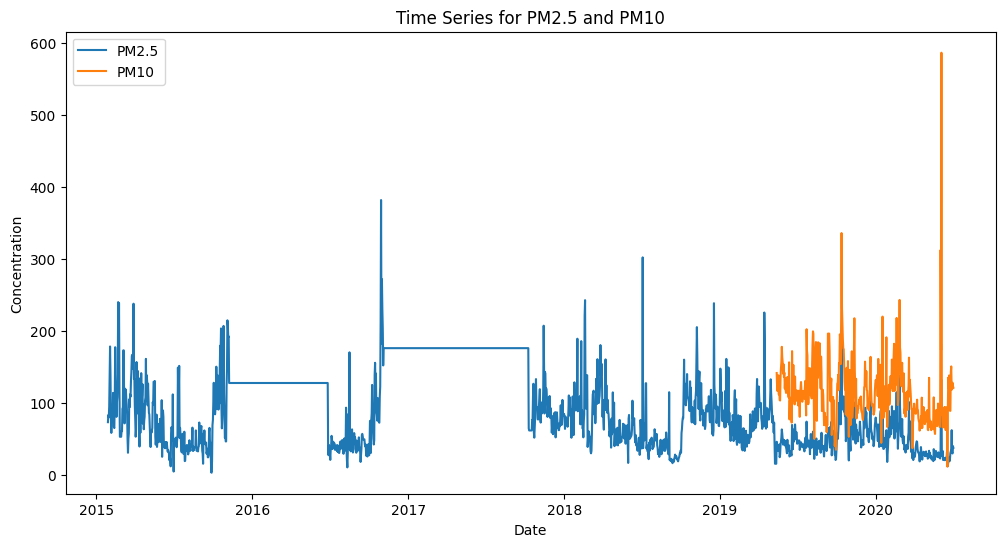

In [ ]:
# Visualize Pollutants
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x=df.index, y='PM2.5', label='PM2.5')
sns.lineplot(data=df, x=df.index, y='PM10', label='PM10')
plt.title('Time Series for PM2.5 and PM10')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()
plt.show()



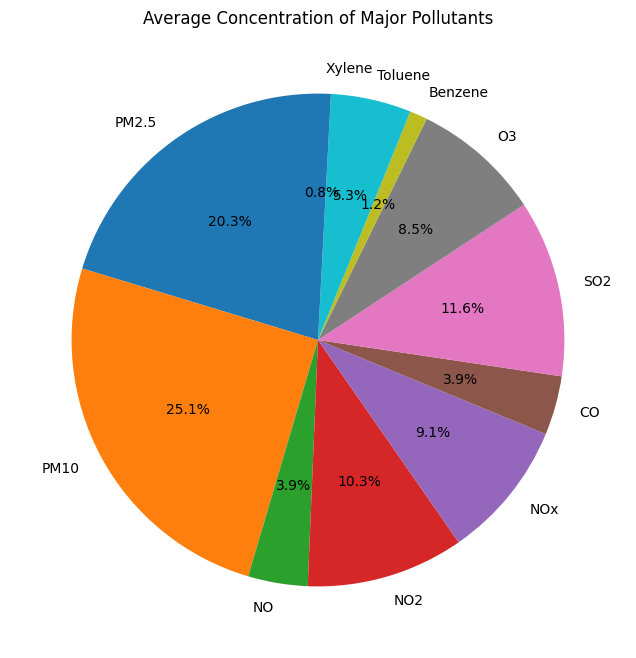

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

pollutants = df.columns[1:12]
# Calculate the average concentration for each pollutant
average_concentrations = df[pollutants].mean()

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(average_concentrations, labels=pollutants, autopct='%1.1f%%', startangle=90)
plt.title('Average Concentration of Major Pollutants')
plt.show()

Histograms for PM2.5, PM10, and other pollutants to visualize their distributions. This can help identify the typical concentration ranges and potential outliers.

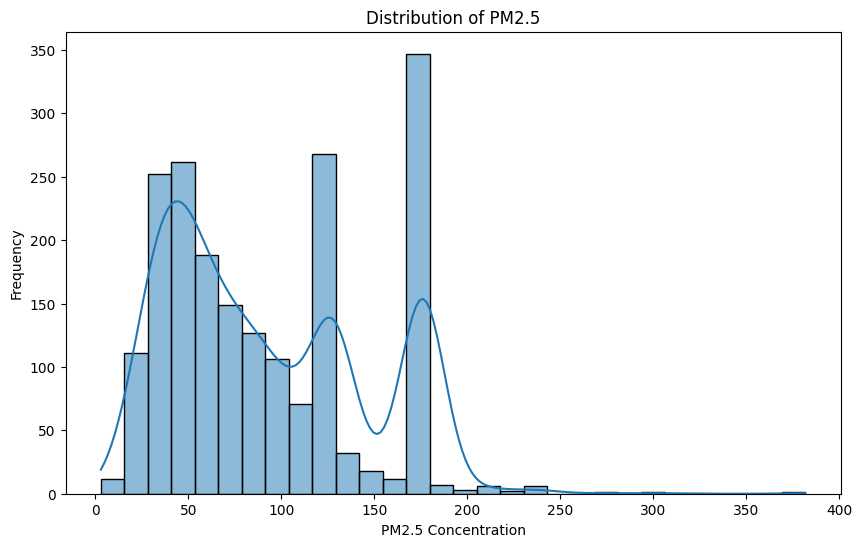

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['PM2.5'], kde=True)
plt.title('Distribution of PM2.5')
plt.xlabel('PM2.5 Concentration')
plt.ylabel('Frequency')
plt.show()

 Temporal Trends and Seasonality:

Seasonal Decomposition: Decompose the time series into trend, seasonality, and residual components using statsmodels.tsa.seasonal.seasonal_decompose. This can help visualize and understand the seasonal patterns in the data.

heatmaps to visualize pollution levels over time, with rows representing days/weeks/months and columns representing hours/days. This can reveal daily or weekly patterns

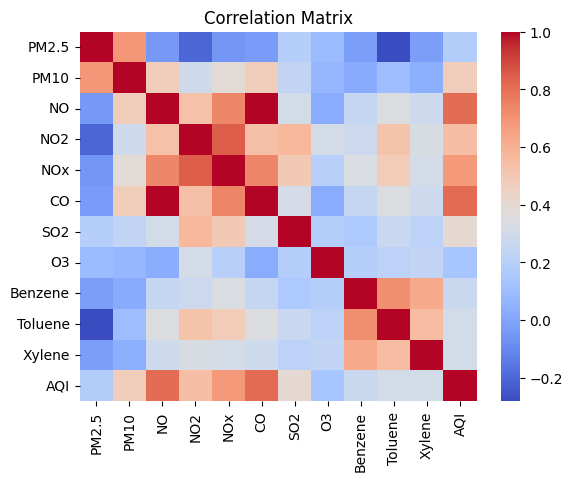

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df.drop(columns=['City']).corr(numeric_only=True)

sns.heatmap(correlation_matrix,  cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Mean Squared Error for PM2.5 forecast: 536.52


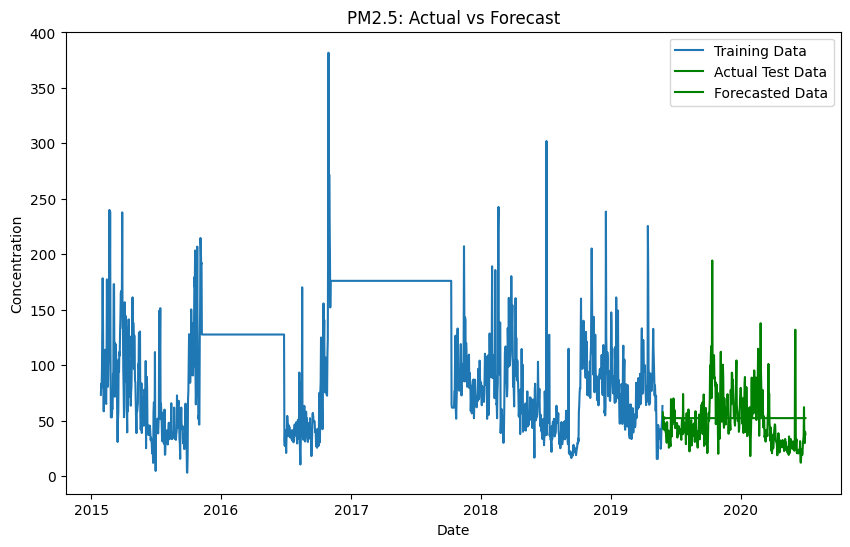

In [ ]:

# Step 1: Data Preparation
target = 'PM2.5'
train_size = int(len(df) * 0.8)
train, test = df[target][:train_size], df[target][train_size:]

# Step 2: Fit ARIMA Model
arima_model = ARIMA(train, order=(5, 1, 0)).fit()

# Step 3: Forecast and Evaluate
forecast = arima_model.forecast(steps=len(test))
mse = mean_squared_error(test, forecast)
print(f'Mean Squared Error for PM2.5 forecast: {mse:.2f}')

# Step 4: Plot Actual vs Forecast
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Test Data', color='green')
plt.plot(test.index, forecast, label='Forecasted Data', color='green')
plt.title('PM2.5: Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()
plt.show()




In [ ]:
# Step 4: Interactive Visualization with Plotly
fig = px.line(df, x=df.index, y=['PM2.5'], title="Pollutant Levels Over Time")
fig.show()



In [ ]:
# Step 5: Dashboard
from bokeh.models import ColumnDataSource, Select
from bokeh.layouts import column
import panel as pn

pn.extension()

source = ColumnDataSource(df.reset_index())  # Initial setup

select = Select(title="Pollutant", value="PM2.5", options=list(df.columns))

def update_plot(attr, old, new):
    selected_data = df[[new]].reset_index()  # Reset index to keep 'Date'
    source.data = {'Date': selected_data['Date'], new: selected_data[new]}

select.on_change('value', update_plot)

plot = figure(x_axis_type='datetime', title='Air Quality Trends', height=400, width=800)
plot.line('Date', 'PM2.5', source=source)  # Initial pollutant plot
layout = column(select, plot)

pn.Column(layout).servable()


Column
    [0] Bokeh(Column)